# Noise Correlation Test
### (Adapted from Apercal tutorial 2:  Calibration and imaging of several APERTIF element beams)

Let's start the pipeline as we do in the tutorials.  Remember to change all the directory paths to your own.

In [1]:
import os;
myusername = os.environ['USER']
if not ('PYTHONPATH' in os.environ and
        '/home/' + myusername + '/apercal' in os.environ['PYTHONPATH']):
      print("WARNING: your apercal directory should be in the $PYTHONPATH")

%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/{}/m51/m51_noise_correlation.log'.format(myusername))

import apercal

/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/hess/m51/m51_noise_correlation.log


Setup logger with lib.setup_logger()


Load the config file for the tutorial and look at it.

In [2]:
prepare = apercal.prepare('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
prepare.show(showall=True)

PREPARE - INFO : ### Configuration file /home/hess/m51/m51_noise_correlation.cfg successfully read! ###


INITIAL
	apercaldir = /home/hess/apercal
	fluxcal = 
	polcal = 
	target = M51.MS
	basedir = /data/hess/apertif/180223003_M51_all/
	beam = 00
	rawsubdir = raw
	crosscalsubdir = crosscal
	selfcalsubdir = selfcal
	linesubdir = line
	contsubdir = continuum
	polsubdir = polarisation
	mossubdir = mosaics
	transfersubdir = transfer
PREPARE
	prepare_obsdir_fluxcal = 
	prepare_obsdir_polcal = 
	prepare_obsdir_target = /data/apertif/180223003_M51_all/
	prepare_obsmode = multi_element
PREFLAG
	preflag_manualflag = True
	preflag_manualflag_fluxcal = True
	preflag_manualflag_polcal = False
	preflag_manualflag_target = True
	preflag_manualflag_auto = True
	preflag_manualflag_antenna = 
	preflag_manualflag_corr = 
	preflag_manualflag_shadow = True
	preflag_manualflag_baseline = 
	preflag_manualflag_channel = 
	preflag_manualflag_time = 
	preflag_aoflagger = True
	preflag_aoflagger_bandpass = True
	preflag_aoflagger_fluxcal = True
	preflag_aoflagger_polcal = False
	preflag_aoflagger_target = True
	pre

# IF DATA IS CALIBRATED, SKIP AHEAD TO "START HERE".

We have to set `prepare_obsmode = multi_element` since these observations were carried out with the full bandwidth in multi-element mode. The prepare step will copy all 37 beams. You might want to stop the step after the third or fourth copied target dataset. The full processing of all beams would need around a day. The pipeline will still work with fewer copied beams, but you need enough adjacent beams for the noise correlation measurement to make sense.
Just make sure that all datasets in your directory are correct and not corrupted (most likely you will have to remove the last copied dataset manually since it wasn't copied completely). <br>
You can also skip the calibration steps in this notebook and go to "Start Here", if you have already calibrated your data elsewhere.

In [ ]:
prepare.go()

As before we have to execute the individual preflag substeps manually.

In [ ]:
preflag = apercal.preflag('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))

nchannel = 11008

a = range(0, nchannel, 64) # the subband edges
b = range(1, nchannel, 64)
c = range(63, nchannel, 64)
d = range(16, nchannel, 64) # the two ghosts
e = range(48, nchannel, 64)
l = a + b + c + d + e
preflag.preflag_manualflag_channel = ';'.join(str(ch) for ch in l)

preflag.show()

We want to flag auto-correlations and shadowed antennas. The preflag step automatically recognises the other beams and flags them as well using the same pattern.

In [ ]:
preflag.manualflag()

First derive the bandpass for the flagging. This is automatically applied to all target element beams.

In [ ]:
#preflag.aoflagger_bandpass()

Now start aoflagger to flag all the datasets automatically.

In [ ]:
#preflag.aoflagger_flag()

Now convert the data to MIRIAD format. Also the CONVERT step takes care of all the different element beams automatically.

In [ ]:
convert = apercal.convert('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
convert.show()
convert.go()

We will do the cross calibration now. The pipeline automatically copies the calibrator solutions over to all element beams (`crosscal_transfer_to_target = True`). Even though the cable delay is in place, we still need to solve for delays due to the 5ns sampling (`crosscal_delay = True`).

In [ ]:
ccal = apercal.ccal('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
ccal.show()
ccal.go()

First we reduce all beams with the same standard paramaters.

In [ ]:
scal = apercal.scal('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
scal.show()

You can easily make a list of the available beams for your dataset.

In [ ]:
import glob
from subs import managefiles

managefiles.director(scal,'ch', scal.basedir)
beams = glob.glob('[0-9][0-9]')
print(beams)

Now iterate over the list of beams with the SELFCAL module and execute the self calibration.

In [ ]:
for beam in beams:
    scal.beam = beam
    scal.go()
scal.go()

If you are satisfied with the self-calibration of all your beams, let's do a continuum image to check that there is sensible data there.  Print the inputs and then iterate over all the beams.  Note that this is really a sanity check, and you can probably skip it if all you are interested in is the noise calibration.

In [ ]:
continuum = apercal.continuum('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
continuum.show()

Image the individual beams using the full data set

In [ ]:
for beam in beams:
    continuum.beam = beam
    continuum.go()

# START NOISE CORRELATION SPECIFIC STEPS HERE

After selfcaling the data, we want to split it into two independent epochs with the same UV coverage.  We will do this by copying the entire selfcal'ed directory structure into Epoch 1 "ep1" and Epoch 2 "ep2" folders, then flagging alternating time segments in each epoch.

In [3]:
# If you skipped the calibration stuff, run this line to set up the directory variables
scal = apercal.scal('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
scal.show()

SELFCAL - INFO : ### Configuration file /home/hess/m51/m51_noise_correlation.cfg successfully read! ###


SELFCAL
	selfcal_image_imsize = 2049
	selfcal_image_cellsize = 4
	selfcal_refant = 
	selfcal_splitdata = True
	selfcal_splitdata_chunkbandwidth = 0.02
	selfcal_splitdata_channelbandwidth = 0.001
	selfcal_flagantenna = 
	selfcal_flagline = True
	selfcal_flagline_sigma = 0.5
	selfcal_parametric = True
	selfcal_parametric_skymodel_radius = 0.5
	selfcal_parametric_skymodel_cutoff = 0.8
	selfcal_parametric_skymodel_distance = 30
	selfcal_parametric_solint = 5
	selfcal_parametric_uvmin = 0.5
	selfcal_parametric_uvmax = 1000
	selfcal_parametric_amp = False
	selfcal_standard_majorcycle = 3
	selfcal_standard_majorcycle_function = square
	selfcal_standard_minorcycle = 3
	selfcal_standard_minorcycle_function = square
	selfcal_standard_c0 = 10.0
	selfcal_standard_c1 = 5.0
	selfcal_standard_minorcycle0_dr = 5.0
	selfcal_standard_drinit = 50
	selfcal_standard_dr0 = 2.0
	selfcal_standard_nsigma = 45
	selfcal_standard_uvmin = [0.0, 0.0, 0.0]
	selfcal_standard_uvmax = [3000, 3000, 3000]
	selfcal_standa

In [4]:
import glob
from subs import managefiles

In [11]:
# Make list of all beam+freq miriad files which have been selfcal'ed 
# (and therefore has a gains table)
managefiles.director(scal,'ch', scal.basedir)
beam_freq_chunks = glob.glob('[0-9][0-9]/selfcal/[0-9][0-9]/*mir')

In [ ]:
# Make the ep1/ directory and copy the selfcal'ed data, masks, and images there:
for chunk in beam_freq_chunks:
    managefiles.director(scal,'mk', scal.basedir+'ep1/'+chunk[:-6])
    managefiles.director(scal,'cp', scal.basedir+'ep1/'+chunk[:-6],file=chunk)
    managefiles.director(scal, 'cp', scal.basedir+'ep1/'+chunk[:-6]+'/', \
                         file=scal.basedir+chunk[:-6]+'/0*')
    
# Make the ep2/ directory and copy the selfcal'ed data, masks, and images there:
for chunk in beam_freq_chunks:
    managefiles.director(scal,'mk', scal.basedir+'ep2/'+chunk[:-6])
    managefiles.director(scal,'cp', scal.basedir+'ep2/'+chunk[:-6],file=chunk)
    managefiles.director(scal, 'cp', scal.basedir+'ep2/'+chunk[:-6]+'/', \
                         file=scal.basedir+chunk[:-6]+'/0*')

Now grab the start and end times from the target observations.  If you don't have the raw data, you need to copy it. For example:

In [5]:
import casac
tb = casac.casac.table()
tb.open(scal.basedir+scal.beam+'/'+scal.rawsubdir+'/'+scal.target[:-3]+'MS/OBSERVATION/')
starttime=tb.getcol('TIME_RANGE')[0][0]
endtime=tb.getcol('TIME_RANGE')[1][0]
tb.close()

print(starttime,endtime)

(5026136613.8880005, 5026178014.208)


Now create a string that includes the time ranges to flag every other 5 minutes (300 seconds) in ep1 and the opposite in ep2, by using the start time of the target observations as a reference point.

In [6]:
from astropy.time import Time
import numpy as np
from astropy import units as u

flag_range=300 #seconds

times=np.arange(starttime,endtime+flag_range*1,flag_range)
alltimes=Time(times/3600./24.,format='mjd',scale='utc')
alltimes.format='iso'

epoch1_flags = ''
epoch2_flags = ''
for i in range(0,len(alltimes)-2,2):
    epoch1_flags+='time({0:%y}{0:%b}{0:%d}:{0:%X},{1:%y}{1:%b}{1:%d}:{1:%X}),'. \
                  format(alltimes[i].datetime,alltimes[i+1].datetime)
    epoch2_flags+='time({0:%y}{0:%b}{0:%d}:{0:%X},{1:%y}{1:%b}{1:%d}:{1:%X}),'. \
                  format(alltimes[i+1].datetime,alltimes[i+2].datetime)

Now do the flagging.  This goes pretty quickly given that it's doing 2*(37*7)=518 beam+freq chunks

In [ ]:
import libs.lib as lib
uvflag=lib.miriad('uvflag')
uvflag.flagval="flag"

for chunk in beam_freq_chunks:
    uvflag.vis=scal.basedir+'ep1/'+chunk
    for s in range(len(epoch1_flags)/960):    #960 is the character length for a given time selection.
        uvflag.select='"'+epoch1_flags[960*s:960*s+960-1]+'"'
    uvflag.go()

for chunk in beam_freq_chunks:
    uvflag.vis=scal.basedir+'ep2/'+chunk
    for s in range(len(epoch2_flags)/960):
        uvflag.select='"'+epoch2_flags[960*s:960*s+960-1]+'"'
    uvflag.go()

Now let's make continuum images of the first epoch.  Start by reading in the configuration file.

In [7]:
continuum = apercal.continuum('/home/{}/m51/m51_noise_correlation.cfg'.format(myusername))
continuum.basedir=scal.basedir+'ep1/'
continuum.show()
#continuum.reset()

CONTINUUM - INFO : ### Configuration file /home/hess/m51/m51_noise_correlation.cfg successfully read! ###


CONTINUUM
	continuum_image_imsize = 2049
	continuum_image_cellsize = 4
	continuum_image_centre = 
	continuum_image_convolbeam = 
	continuum_image_robust = 
	continuum_majorcycle_function = square
	continuum_minorcycle_function = square
	continuum_minorcycle0_dr = 5.0
	continuum_minorcycle = 3
	continuum_c0 = 10.0
	continuum_c1 = 5.0
	continuum_drinit = 50
	continuum_dr0 = 2.0
	continuum_nsigma = 45


Change into the *NEW* ep1 base directory and iterate over all beams.  This will make continuum images for the individual spws and stack them.

In [ ]:
managefiles.director(continuum,'ch', continuum.basedir)
beams = glob.glob('[0-9][0-9]')

#beam 02, chunk 04 has a noise problem
#beam 15, chunks 02-07 were not successfully calibrated..check output!
#check beam 19...(similar issue as 02)
for beam in beams:
    if (beam != '02') and (beam != '19'):
#        print beam
        continuum.beam = beam
        continuum.go()

#grab errors after 06/04/2018 05:00:42 PM (was at beam 27, chunk 04)

CONTINUUM - INFO : ########## Starting CONTINUUM IMAGING of beam 00 ##########
CONTINUUM - INFO : ### Starting deep continuum imaging of full dataset ###
CONTINUUM - INFO : ### Continuum imaging for chunk 00 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###


In [25]:
# Let's do some investigating the errors from the log
continuum.beam = '02'
cs = continuum.summary()
cs.style

d = dict(selector="th", props=[('text-align', 'center')])
cs.style.set_properties(**{'text-align':'center'})

,Iterations,Success?,"Bmaj [""]","Bmin [""]",Bpa [deg],Image weight,Accepted?,Reason
00,2,True,19.95,16.91,5.38,0.13493,True,
01,2,True,19.88,16.93,5.17,0.14251,True,
02,2,True,19.66,16.73,4.72,0.1871,True,
03,2,True,19.47,16.56,5.11,0.24761,True,
04,0,True,19.28,16.38,5.29,0.00894,True,
05,2,True,19.07,16.23,5.17,0.09795,True,
06,2,True,18.74,15.89,4.96,0.1125,True,
07,2,True,18.7,15.88,5.24,0.06846,True,


In [26]:
print continuum.basedir
dcs = continuum.detailed_summary()
dcs.style

d = dict(selector="th", props=[('text-align', 'center')])
dcs.style.set_properties(**{'text-align':'center'})

/data/hess/apertif/180223003_M51_all/epoch1/


Now change into the epoch2 base directory and again, iterate over all beams:

In [ ]:
continuum.basedir=scal.basedir+'ep2/'
managefiles.director(continuum,'ch', continuum.basedir)

beams = glob.glob('[0-9][0-9]')

for beam in beams:
    if (beam != '02') and (beam != '19'):
        continuum.beam = beam
        continuum.go()

CONTINUUM - INFO : ########## Starting CONTINUUM IMAGING of beam 00 ##########
CONTINUUM - INFO : ### Starting deep continuum imaging of full dataset ###
CONTINUUM - INFO : ### Continuum imaging for chunk 00 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###


# Parameter file not found! Cannot load parameter continuum_B00_minoriterations #


CONTINUUM - INFO : ### Continuum imaging for chunk 01 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 02 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 03 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 04 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 05 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 06 started ###
CONTINUUM

CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 02 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 03 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 04 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 05 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 06 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gr

CONTINUUM - INFO : ### Continuum imaging for chunk 03 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 04 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 05 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 06 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 07 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Stacking continuum images of individual frequency ch

CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 05 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 06 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Continuum imaging for chunk 07 started ###
CONTINUUM - WARNING : ### Using pointing centres of individual beams for gridding. Not recommended for mosaicking! ###
CONTINUUM - INFO : ### Stacking continuum images of individual frequency chunks ###
CONTINUUM - INFO : # Final beam size is fwhm = 20.803418146158453 arcsec , 17.06717743031375 arcsec, pa = 6.886815071 deg
CONTINUUM - ERROR : ### Final stacked continuum image could not be created! ###
CONTINUUM - INFO : ########## CONTINUUM 

Great!  Now I have frequency stacked images for every beam in two epochs.  Neighboring beams in the same epoch have some level of correlation, neighboring beams in different epochs have no correlation.  Now we need to compare them...

#LEFT THIS AT EPOCH 2 BEING IMAGED.  NOW LET'S DO THE ANALYSIS!

Make directories to hold the stacked images for each possible combination. e1e1 and e2e2 have images that are stacked from different beams within the same epoch. If they are compound beams, their noise will be correlated.  The e1e2 and e2e1 directories combine neighboring beams from different epochs, so their noise should not be correlated.

In [14]:
managefiles.director(scal,'ch', scal.basedir)
managefiles.director(scal,'mk', scal.basedir+'e1e1/')
managefiles.director(scal,'mk', scal.basedir+'e2e2/')
managefiles.director(scal,'mk', scal.basedir+'e1e2/')
managefiles.director(scal,'mk', scal.basedir+'e2e1/')

Make frequency chunk directories in each of the combined epoch directories.  Note that this is now inverting the beam/chunk directory structure (but I think I have to!)

In [9]:
print scal.basedir
print continuum.image_continuum

/data/hess/apertif/180223003_M51_all/
<bound method continuum.image_continuum of <modules.continuum.continuum instance at 0x7f885871fe18>>


In [17]:
managefiles.director(scal,'ch', continuum.contdir+'/stack/')
freq_chunks = glob.glob('[0-9][0-9]/')

# Make directories for each frequency chunk in each combined epoch
for chunk in freq_chunks:
    managefiles.director(scal,'mk', scal.basedir+'e1e1/'+chunk)
    managefiles.director(scal,'mk', scal.basedir+'e1e2/'+chunk)
    managefiles.director(scal,'mk', scal.basedir+'e2e1/'+chunk)
    managefiles.director(scal,'mk', scal.basedir+'e2e2/'+chunk)

/data/hess/apertif/180223003_M51_all/epoch1/00/continuumstack/
/data/hess/apertif/180223003_M51_all/e1e1/00/
/data/hess/apertif/180223003_M51_all/e1e1/01/
/data/hess/apertif/180223003_M51_all/e1e1/02/
/data/hess/apertif/180223003_M51_all/e1e1/03/
/data/hess/apertif/180223003_M51_all/e1e1/04/
/data/hess/apertif/180223003_M51_all/e1e1/05/
/data/hess/apertif/180223003_M51_all/e1e1/06/
/data/hess/apertif/180223003_M51_all/e1e1/07/


Specify the neighboring unique correlated beams.  There are 94 such combinations because we only compare compound beams that are adjacent to one another.  The first element in each subarray is the compound beam, cb1.  The other elements are the neighboring cbs which will have correlated noise with cb1.

In [24]:
# Based on this: https://sites.google.com/site/apertifimaging/observations/paf-element-layout
elem_beams=(['00','14','15','22','23'],['01','02','04','05'],['02','03','05','06'], \
            ['03','06','07'],['04','05','08','09'],['05','06','09','10'], \
            ['06','07','10','11'],['07','11','12'],['08','09','13'],['09','10','13','14'], \
            ['10','11','14','15'],['11','12','15','16'],['12','16'],['13','14','17','18'], \
            ['14','15','18','00'],['15','16','00','19'],['16','19','20'],['17','18','21'], \
            ['18','00','21','22'],['19','20','23','24'],['20','24'],['21','22','25','26'], \
            ['22','23','26','27'],['23','24','27','28'],['24','28','29'],['25','26','30'], \
            ['26','27','30','31'],['27','28','31','32'],['28','29','32','33'],['29','33'], \
            ['30','31','34'],['31','32','34','35'],['32','33','35','36'],['33','36'], \
            ['34','35'],['35','36'])

# Based on https://drive.google.com/open?id=1bJyUsLy1mwMFn8tnZa-n7Yk6bel3PfZF
corr_beams=(['00','16','17','22','23'],['01','02','08'],['02','03','08','09'],['03','04','09','10'], \
             ['04','05','10','11'],['05','06','11','12'],['06','07','12','13'], \
             ['07','13','14'],['08','09','15'],['09','10','15','16'],['10','11','16','17'], \
             ['11','12','17','18'],['12','13','18','19'],['13','14','19','20'],['14','15','20'], \
             ['15','16','21','22'],['16','17','22','23'],['17','18','23','24'], \
             ['18','19','24','25'],['19','20','25','26'],['20','26'],['21','22','27'], \
             ['22','23','27','28'],['23','24','28','29'],['24','25','29','30'], \
             ['25','26','30','31'],['26','31','32'],['27','28','33','34'],['28','29','34','35'], \
             ['29','30','35','36'],['30','31','36','37'],['31','32','37','38'], \
             ['32','33','38','39'],['33','34'],['34','35'],['35','36'],['36','37'],['37','38'], \
             ['38','39'])

Use the maths task in miriad to combine the images, and put them in the directories.  But also measure the rms for each image to be used later... 
Choose whether this is an element beam image, or a compound beam image.
If it is a composite image, you will have to hard code your own numbering.

In [33]:
import subs.imstats
mirmaths=lib.miriad('maths')

e1e1 = []
e1e2 = []
e2e2 = []
e2e1 = []

stack_name = glob.glob(continuum.basedir+'00/'+continuum.contsubdir+'/'+ \
                        continuum.target.rstrip('.mir') + '_st*')[0]

# THIS IS ONLY FOR THE FULL CONTINUUM IMAGES SO FAR!  NEED TO DO FOR EACH SPW!
for cbs in elem_beams:
#for cbs in corr_beams:
    for beam2 in cbs[1:]:
        im1=scal.basedir+'ep1/'+cbs[0]+'/'+continuum.contsubdir+'/'+stack_name.split('/')[-1]
        im2=scal.basedir+'ep1/'+beam2+'/'+continuum.contsubdir+'/'+stack_name.split('/')[-1]
        imout=scal.basedir+'e1e1/'+cbs[0]+beam2+'.mir'
        mirmaths.exp='"(<'+im1+'>+<'+im2+'>)/2"'
        mirmaths.out=imout
        mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
        #mirmaths.go()
        if os.path.isdir(imout):
            immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
            e1e1.append(imstd)
        else:
            e1e1.append(-0.)

        im2=scal.basedir+'ep2/'+beam2+'/'+continuum.contsubdir+'/'+stack_name.split('/')[-1]
        mirmaths.exp='"(<'+im1+'>+<'+im2+'>)/2"'
        imout=scal.basedir+'e1e2/'+cbs[0]+beam2+'.mir'
        mirmaths.out=imout
        mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
        #mirmaths.go()
        if os.path.isdir(imout):
            immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
            e1e2.append(imstd)
        else:
            e1e2.append(-99.)
            
        im1=scal.basedir+'ep2/'+cbs[0]+'/'+continuum.contsubdir+'/'+stack_name.split('/')[-1]
        mirmaths.exp='"(<'+im1+'>+<'+im2+'>)/2"'
        imout=scal.basedir+'e2e2/'+cbs[0]+beam2+'.mir'
        mirmaths.out=imout
        mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
        #mirmaths.go()
        if os.path.isdir(imout):
            immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
            e2e2.append(imstd)
        else:
            e2e2.append(-0.)
            
        im2=scal.basedir+'ep1/'+beam2+'/'+continuum.contsubdir+'/'+stack_name.split('/')[-1]
        mirmaths.exp='"(<'+im1+'>+<'+im2+'>)/2"'
        imout=scal.basedir+'e2e1/'+cbs[0]+beam2+'.mir'
        mirmaths.out=imout
        mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
        #mirmaths.go()
        if os.path.isdir(imout):
            immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
            e2e1.append(imstd)
        else:
            e2e1.append(-99.)

Let's assume that all went fine.  Now calculate the ratio of the noise between stacked beams with correlated noise and stacked images without correlated noise. Note that there are four possible combinations, which will give us some idea of the error(ish) on a single measurment.

In [46]:
import numpy as np

e1e1 = np.array(e1e1)
e1e2 = np.array(e1e2)
e2e2 = np.array(e2e2)
e2e1 = np.array(e2e1)

# F = rms(correlated stack)/rms(uncorrelated stack)

#print e1e1/e1e2,e1e1/e2e1,e2e2/e1e2,e2e2/e2e1

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

Now plot the results!  Note that we ignore beams which have not been successfully imaged (their values have been set to 0).

RMS of the fractional noise correlation:  0.0058371813573651725
Number of element beam combinations:  89*4=356


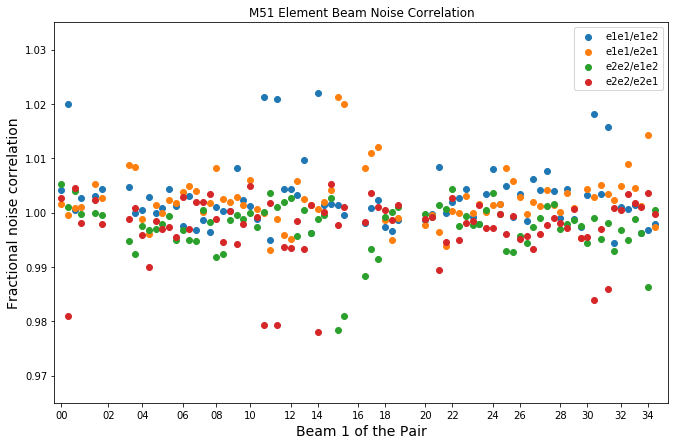

In [162]:
plt.figure(figsize=(11,7))
plt.scatter(range(len(e1e1)),e1e1/e1e2,label="e1e1/e1e2")
plt.scatter(range(len(e1e1)),e1e1/e2e1,label="e1e1/e2e1")
plt.scatter(range(len(e1e1)),e2e2/e1e2,label="e2e2/e1e2")
plt.scatter(range(len(e1e1)),e2e2/e2e1,label="e2e2/e2e1")
rms=np.std([e1e1[e1e1!=0.]/e1e2[e1e1!=0.],e1e1[e1e1!=0.]/e2e1[e1e1!=0.], \
                          e2e2[e1e1!=0.]/e1e2[e1e1!=0.],e2e2[e1e1!=0.]/e2e1[e1e1!=0.]])
plt.ylim(1-6*rms,1+6*rms)
plt.ylabel("Fractional noise correlation",size=14)
plt.xlim(0-1,len(e1e1)+1)
leneid,b1,xv=0,[],[]
for i,eid in enumerate(elem_beams):
    b1.append(eid[0])
    xv.append(leneid)
    leneid+=len(eid)-1
plt.xticks(xv[::2],b1[::2])
plt.xlabel("Beam 1 of the Pair",size=14)
plt.title(continuum.target[:-4]+" Element Beam Noise Correlation")
plt.legend()
print "RMS of the fractional noise correlation: ",rms
print "Number of element beam combinations: ",str(len(e1e1))+"*4="+str(len(e1e1)*4)

Let's figure out whom the outliers are and display them.

In [156]:
b1=[]
b2=[]
for i,e in enumerate(elem_beams): 
    b1=np.append(b1,np.ones(len(e[1:]))*i)
    b2=np.append(b2,e[1:])
print b2[(np.abs(e1e1/e1e2-1)>0.014) & (np.abs(e1e1/e1e2-1)<0.5)], \
         b1[(np.abs(e1e1/e1e2-1)>0.014) & (np.abs(e1e1/e1e2-1)<0.5)]
print b2[(np.abs(e2e2/e1e2-1)>0.014) & (np.abs(e2e2/e1e2-1)<0.5)], \
         b1[(np.abs(e2e2/e1e2-1)>0.014) & (np.abs(e2e2/e1e2-1)<0.5)]
print b2[(np.abs(e1e1/e2e1-1)>0.014) & (np.abs(e1e1/e2e1-1)<0.5)], \
         b1[(np.abs(e1e1/e2e1-1)>0.014) & (np.abs(e1e1/e2e1-1)<0.5)]
print b2[(np.abs(e2e2/e2e1-1)>0.014) & (np.abs(e2e2/e2e1-1)<0.5)], \
         b1[(np.abs(e2e2/e2e1-1)>0.014) & (np.abs(e2e2/e2e1-1)<0.5)]

['15' '15' '15' '15' '34' '34'] [ 0. 10. 11. 14. 30. 31.]
['16' '00'] [15. 15.]
['16' '00' '35'] [15. 15. 34.]
['15' '15' '15' '15' '34' '34'] [ 0. 10. 11. 14. 30. 31.]


NEXT STEPS:
    (3) TEST ON EITHER BJORN'S LH DATA
    (5) ASK FOR COMPOUND BEAM DATA (EVEN IF BEAMS ARE POORLY BEHAVED)

Let's work on editing a cell from above to do individual chunks (then we need to do this properly for actual subbands!)

In [48]:
import subs.imstats
mirmaths=lib.miriad('maths')

e1e1 = []
e1e2 = []
e2e2 = []
e2e1 = []

# THIS IS FOR FREQUENCY CHUNK IMAGES.  NEED TO DO BREAK UP BY SUBBAND WELL IN THE BEGINNING OF THE NOTEBOOK!
for chunk in freq_chunks:
    for cbs in elem_beams:
        #for cbs in corr_beams:
        for beam2 in cbs[1:]:
            im1=glob.glob(scal.basedir+'ep1/'+cbs[0]+'/'+continuum.contsubdir+'/stack/'+chunk+'image*') or -1
            im2=glob.glob(scal.basedir+'ep1/'+beam2+'/'+continuum.contsubdir+'/stack/'+chunk+'image*') or -1
            imout=scal.basedir+'e1e1/'+chunk+'/'+cbs[0]+beam2+'.mir'
            if (im1 != -1) & (im2 != -1):
                mirmaths.exp='"(<'+im1[-1]+'>+<'+im2[-1]+'>)/2"'
                mirmaths.out=imout
                mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
                #mirmaths.go()
            if os.path.isdir(imout):
                immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
                e1e1.append(imstd)
            else:
                e1e1.append(-0.)

            im2=glob.glob(scal.basedir+'ep2/'+beam2+'/'+continuum.contsubdir+'/stack/'+chunk+'image*') or -1
            if (im1 != -1) & (im2 != -1):
                mirmaths.exp='"(<'+im1[-1]+'>+<'+im2[-1]+'>)/2"'
                imout=scal.basedir+'e1e2/'+chunk+'/'+cbs[0]+beam2+'.mir'
                mirmaths.out=imout
                mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
                #mirmaths.go()
            if os.path.isdir(imout):
                immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
                e1e2.append(imstd)
            else:
                e1e2.append(-99.)
            
            im1=glob.glob(scal.basedir+'e2/'+cbs[0]+'/'+continuum.contsubdir+'/stack/'+chunk+'image*') or -1
            if (im1 != -1) & (im2 != -1):
                mirmaths.exp='"(<'+im1[-1]+'>+<'+im2[-1]+'>)/2"'
                imout=scal.basedir+'e2e2/'+chunk+'/'+cbs[0]+beam2+'.mir'
                mirmaths.out=imout
                mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
                #mirmaths.go()
            if os.path.isdir(imout):
                immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
                e2e2.append(imstd)
            else:
                e2e2.append(-0.)
            
            im2=glob.glob(scal.basedir+'e1/'+beam2+'/'+continuum.contsubdir+'/stack/'+chunk+'image*') or -1
            if (im1 != -1) & (im2 != -1):
                mirmaths.exp='"(<'+im1[-1]+'>+<'+im2[-1]+'>)/2"'
                imout=scal.basedir+'e2e1/'+chunk+'/'+cbs[0]+beam2+'.mir'
                mirmaths.out=imout
                mirmaths.region='"boxes(0,0,'+str(2048*0.2)+',2048)"'
                mirmaths.go()
            if os.path.isdir(imout):
                immin, immax, imstd = subs.imstats.getimagestats(continuum,imout)
                e2e1.append(imstd)
            else:
                e2e1.append(-99.)

In [49]:
e1e1 = np.array(e1e1)
e1e2 = np.array(e1e2)
e2e2 = np.array(e2e2)
e2e1 = np.array(e2e1)

Let's plot the noise correlation for each frequency chunk

RMS of the fractional noise correlation:  0.008697608674362005
Number of element beam combinations:  712*4=2848


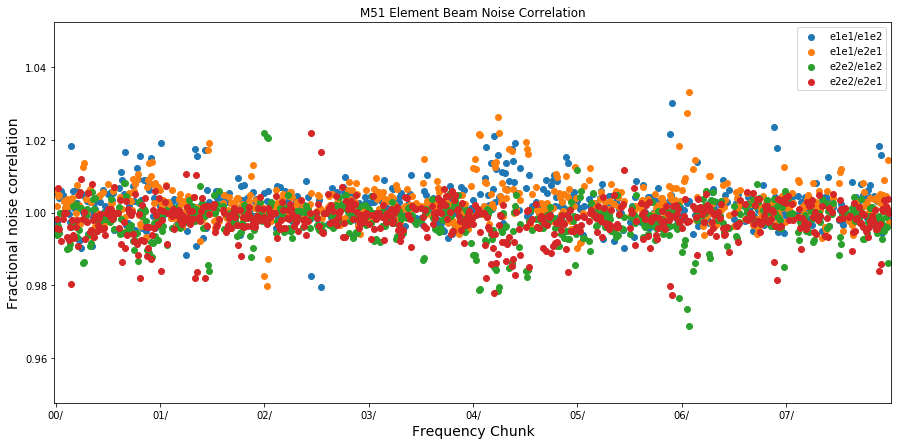

In [71]:
plt.figure(figsize=(15,7))
plt.scatter(range(len(e1e1)),e1e1/e1e2,label="e1e1/e1e2")
plt.scatter(range(len(e1e1)),e1e1/e2e1,label="e1e1/e2e1")
plt.scatter(range(len(e1e1)),e2e2/e1e2,label="e2e2/e1e2")
plt.scatter(range(len(e1e1)),e2e2/e2e1,label="e2e2/e2e1")
rms=np.std([e1e1[e1e1!=0.]/e1e2[e1e1!=0.],e1e1[e1e1!=0.]/e2e1[e1e1!=0.], \
                          e2e2[e1e1!=0.]/e1e2[e1e1!=0.],e2e2[e1e1!=0.]/e2e1[e1e1!=0.]])
plt.ylim(1-6*rms,1+6*rms)
plt.ylabel("Fractional noise correlation",size=14)
plt.xlim(0-1,len(e1e1)+1)
leneid,b1,xv=0,[],[]
for i,eid in enumerate(elem_beams):
    b1.append(eid[0])
    xv.append(leneid)
    leneid+=len(eid)-1
#plt.xticks(xv[::2],b1[::2])
len(e1e1)/len(elem_beams)
plt.xticks([leneid*i for i in range(len(freq_chunks))],freq_chunks)
plt.xlabel("Frequency Chunk",size=14)
plt.title(continuum.target[:-4]+" Element Beam Noise Correlation")
plt.legend()
print "RMS of the fractional noise correlation: ",rms
print "Number of element beam combinations: ",str(len(e1e1))+"*4="+str(len(e1e1)*4)